# NARX shoreline model results
This notebook is designed to plot 

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [58]:
import sys, os, re
import glob, pickle
import numpy as np
import pandas as pd
from shoreNARX import TrainingClass
from shoreNARX.model_class import calc_performance_
from shoreNARX.plotting import (
    plot_compare_datareq, plot_compare_sattest
)
# from shoreNARX.analyses import ()

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
baseLoc = '.'
# set pandas print format to 3 decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Report model performance 
With optimised hyperparams and 5-fold CV.

trainObj.statsOut gives a [[{} * CV_folds] * random_states] object

First define a function that loads the model results for a given config file.

In [52]:
def load_model_results(config_file):
    # init object
    config_path = os.path.join(baseLoc,'config',config_file)
    trainObj = TrainingClass(**{'baseDir':baseLoc,'config':config_path})
    # train as per config
    trainObj.load_cv_test()
    
    # get the train/test splits
    ttCombs = trainObj.trainCombs
    # get the fold and data perc
    ttFold = np.argmax(ttCombs==1,axis=1)/2
    # get data perc
    ttPerc = np.sum(ttCombs==2,axis=1)*100/ttCombs.shape[1]
    combsData = pd.DataFrame(
        {'fold':ttFold,'perc':ttPerc,'num':np.arange(ttCombs.shape[0])}
    )

    # data collector
    dataCollector = []

    # get the performance metrics for each fold and ensemble
    for thisFold in np.arange(trainObj.statsOut[0].__len__()):
        for thisEnsemble in np.arange(trainObj.statsOut.__len__()):
            tmpRMSE, tmpNMSE, tmpR, tmpR2 = calc_performance_(
                trainObj.statsOut[thisEnsemble][thisFold]['test']['modY'],
                trainObj.statsOut[thisEnsemble][thisFold]['test']['obsY']
            )
            dataCollector.append(
                {
                    'testRMSE': tmpRMSE,
                    'testNMSE': tmpNMSE,
                    'testR': tmpR,
                    'testR2': tmpR2,
                    'num': thisFold,
                    'ensemble': thisEnsemble,
                }
            )

    # collate dataCollector into a dataframe
    performanceData = pd.DataFrame(dataCollector)
    performanceData = pd.merge(performanceData,combsData,left_on='num',right_on='num')
    performanceData['site'] = trainObj.site

    print('Performance by fold:')
    # now calculate the by fold std
    std_byFold = performanceData.drop(columns='site').groupby(by='fold').std()
    std_byFold = std_byFold[['testRMSE','testNMSE','testR','testR2']]
    std_byFold.columns = ['(std testRMSE)','(std testNMSE)','(std testR)','(std testR3)']
    byFold = pd.concat([
        performanceData.drop(columns='site').groupby(by='fold').mean(),
        std_byFold
    ], axis=1).drop(columns=['ensemble'])
    display(byFold)


    return trainObj, performanceData

Narrabeen performance check

In [60]:
case = 'datareq'

print('#'*80)
print('Narrabeen')
narra_base, narra_base_perf = load_model_results('narra_{}_config.json'.format(case))
print('#'*80)
print('Tairua')
tairua_base, tairua_base_perf = load_model_results('tairua_{}_config.json'.format(case))

################################################################################
Narrabeen
Performance by fold:


,testRMSE,testNMSE,testR,testR2,num,perc,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,,,
0.000,8.567,1.284,0.620,0.295,3.500,45.000,3.490,1.168,0.178,0.051
1.000,7.337,0.778,0.703,0.308,11.500,45.000,2.239,0.542,0.108,0.087
2.000,6.222,0.627,0.785,0.041,19.500,45.000,2.553,0.592,0.124,0.111
3.000,9.094,1.341,0.774,0.344,27.500,45.000,3.979,1.410,0.121,0.048
4.000,8.178,0.879,0.726,0.148,35.500,45.000,3.627,1.035,0.121,0.064


################################################################################
Tairua
Performance by fold:


,testRMSE,testNMSE,testR,testR2,num,perc,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,,,
0.000,5.061,0.665,0.608,0.278,3.500,45.000,0.454,0.120,0.093,0.059
1.000,4.744,1.147,0.405,0.115,11.500,45.000,0.789,0.387,0.154,0.186
2.000,5.112,0.640,0.635,0.299,19.500,45.000,0.535,0.138,0.142,0.066
3.000,4.111,0.724,0.589,0.171,27.500,45.000,0.459,0.167,0.092,0.100
4.000,5.350,1.187,0.248,-0.031,35.500,45.000,0.390,0.175,0.095,0.114


# Plot the model performance
## Data requirements

In [61]:
comb_datareq = pd.concat([narra_base_perf,tairua_base_perf],axis=0)
comb_datareq.head()

,testRMSE,testNMSE,testR,testR2,num,ensemble,fold,perc,site
0,6.929,0.722,0.536,0.214,0,0,0.000,10.000,narra
1,9.250,1.286,0.388,0.267,0,1,0.000,10.000,narra
2,14.964,3.366,0.644,0.176,0,2,0.000,10.000,narra
3,15.904,3.802,0.612,0.149,0,3,0.000,10.000,narra
4,6.738,0.682,0.578,0.233,0,4,0.000,10.000,narra


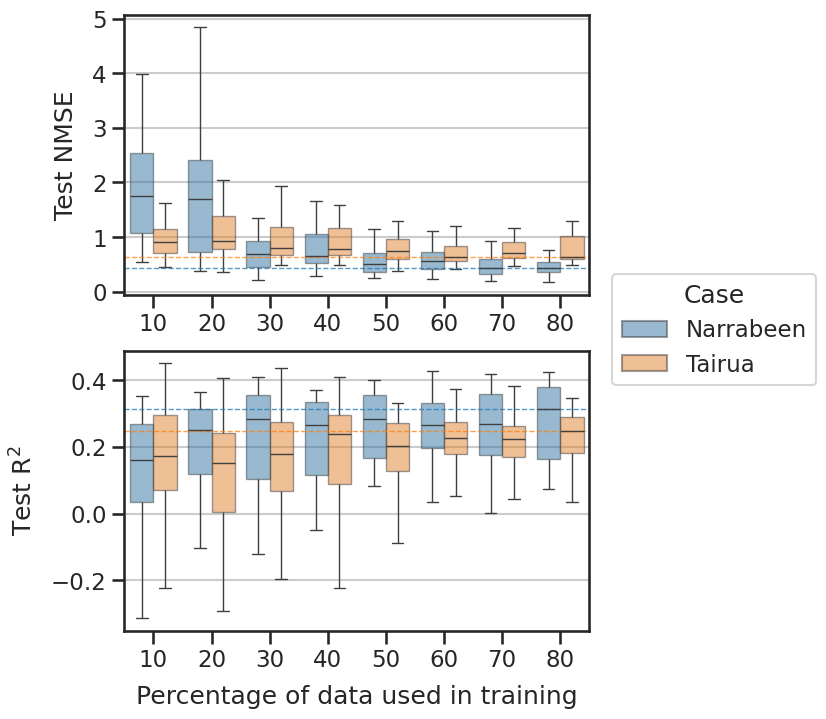

In [68]:
plot_compare_datareq(comb_datareq, savebool=False, showfliers=False)

## Satellite data simulation

In [ ]:
case = 'sattest'

print('#'*80)
print('Narrabeen')
_, narra_sattest_perf = load_model_results('narra_{}_config.json'.format(case))
print('#'*80)
print('Tairua')
_, tairua_sattest_perf = load_model_results('tairua_{}_config.json'.format(case))